### Лабораторная работа 1-2
##### Шиленок Даниил ИУ5-65Б

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway

data = pd.read_csv(f"crop_production.csv")

In [315]:
print(data.head())
print(data.info())

                    State_Name District_Name  Crop_Year       Season  \
0  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    

                  Crop    Area  Production  
0             Arecanut  1254.0      2000.0  
1  Other Kharif pulses     2.0         1.0  
2                 Rice   102.0       321.0  
3               Banana   176.0       641.0  
4            Cashewnut   720.0       165.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Cr

#### Проверим на пропуски

In [316]:
missing_data = data.isnull().sum()
print("Количество пропусков в каждой колонке:")
print(missing_data[missing_data>0])
zero_production = data[data['Production'] == 0]

Количество пропусков в каждой колонке:
Production    3730
dtype: int64


#### Проверим на дубликаты:

In [317]:
print("Количество дубликатов:")
print(data.duplicated().sum())

Количество дубликатов:
0


#### Устраним пропуски

In [318]:
data = data.dropna()
missing_data = data.isnull().sum()
print("Количество пропусков в каждой колонке:")
print(missing_data[missing_data>0])
data = data[data['Production'] > 0]


Количество пропусков в каждой колонке:
Series([], dtype: int64)


#### Устраним выбросы в столбце Production

In [319]:
Q1 = data['Production'].quantile(0.25)
Q3 = data['Production'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Production'] >= lower_bound) & (data['Production'] <= upper_bound)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197206 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     197206 non-null  object 
 1   District_Name  197206 non-null  object 
 2   Crop_Year      197206 non-null  int64  
 3   Season         197206 non-null  object 
 4   Crop           197206 non-null  object 
 5   Area           197206 non-null  float64
 6   Production     197206 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 12.0+ MB


#### Агрегируем данные

1) Общая площадь и производство для каждой культуры

In [320]:
aggregated_crops = data.groupby('Crop').agg(
    Total_Area=('Area', 'sum'),
    Total_Production=('Production', 'sum')
).reset_index()

print(aggregated_crops)

                    Crop   Total_Area  Total_Production
0    Arcanut (Processed)     53489.00          65945.00
1               Arecanut   3226915.73        3647160.27
2              Arhar/Tur  25573245.21       15449037.33
3          Atcanut (Raw)      9057.00          53529.00
4                  Bajra  16369699.00       10568093.00
..                   ...          ...               ...
100                 Urad  33325916.00       13659889.66
101               Varagu     47766.00          49694.00
102                Wheat   8051509.78        8756206.80
103   other misc. pulses     30833.00           9704.22
104       other oilseeds    857389.86         490340.81

[105 rows x 3 columns]


2) Среднее производство и площадь по сезонам

In [321]:
aggregated_seasons = data.groupby('Season').agg(
    Avg_Area=('Area', 'mean'),
    Avg_Production=('Production', 'mean')
).reset_index()

print(aggregated_seasons)

        Season     Avg_Area  Avg_Production
0  Autumn       3234.083973     3409.923898
1  Kharif       2993.389286     1980.600264
2  Rabi         2355.805893     2031.005773
3  Summer       1678.007849     1820.746947
4  Whole Year   1175.041496     2062.861488
5  Winter       2112.113473     1771.410562


3) Максимальноe, минимальное, среднее и суммарное производство для каждой культуры по штатам

In [322]:
aggregated_states = data.groupby(['State_Name', 'Crop']).agg(
    Max_Production=('Production', 'max'),
    Min_Production=('Production', 'min'),
    Avg_Production=('Production', 'mean'),
    Sum_Production=('Production', 'sum')
).reset_index()

print(aggregated_states)

                       State_Name          Crop  Max_Production  \
0     Andaman and Nicobar Islands      Arecanut         5267.00   
1     Andaman and Nicobar Islands     Arhar/Tur           90.80   
2     Andaman and Nicobar Islands        Banana        17374.40   
3     Andaman and Nicobar Islands  Black pepper          191.14   
4     Andaman and Nicobar Islands     Cashewnut          260.50   
...                           ...           ...             ...   
1154                  West Bengal     Sunflower        12800.00   
1155                  West Bengal       Tobacco        17574.00   
1156                  West Bengal      Turmeric         8810.00   
1157                  West Bengal          Urad        14040.00   
1158                  West Bengal         Wheat        18030.00   

      Min_Production  Avg_Production  Sum_Production  
0             477.60     2825.635882        48035.81  
1              13.20       52.000000          104.00  
2             404.12     6089.

4) Суммарное производство и среднее значение по годам

In [323]:
aggregated_years = data.groupby(['Crop_Year']).agg(
    Sum_Production=('Production', 'sum'),
    Avg_Production=('Production', 'mean')
).reset_index()

print(aggregated_years)

    Crop_Year  Sum_Production  Avg_Production
0        1997     16697997.00     2440.157387
1        1998     20474749.00     2272.951710
2        1999     23030642.80     2297.320978
3        2000     23371128.10     2097.758558
4        2001     22526345.27     2069.485096
5        2002     25102493.24     1963.433183
6        2003     27550228.43     2120.716529
7        2004     23288063.47     2034.602784
8        2005     22852839.25     2042.985808
9        2006     23005259.99     1986.808877
10       2007     22232619.85     1857.206570
11       2008     22881849.49     1950.046829
12       2009     21786211.19     1913.925256
13       2010     22194717.01     1967.267950
14       2011     22332091.44     1969.667617
15       2012     21067833.63     1933.538329
16       2013     21511824.28     1923.962461
17       2014     17126940.71     1896.881239
18       2015       624362.20     1241.276740


5) Средняя урожайность (Production/Area) для каждой культуры

In [324]:
data['Yield'] = data['Production'] / data['Area']
avg_yield = data.groupby('Crop').agg(
    Avg_Yield=('Yield', 'mean')
).reset_index()

print(avg_yield)

                    Crop  Avg_Yield
0    Arcanut (Processed)   1.268703
1               Arecanut   1.731664
2              Arhar/Tur   0.791511
3          Atcanut (Raw)   6.071864
4                  Bajra   1.129991
..                   ...        ...
100                 Urad   0.493349
101               Varagu   0.931066
102                Wheat   1.361542
103   other misc. pulses   0.250552
104       other oilseeds   1.026731

[105 rows x 2 columns]


6) Суммарное производство по штатам

In [325]:
state_production = data.groupby('State_Name')['Production'].sum().reset_index()
print(state_production)

                     State_Name   Production
0   Andaman and Nicobar Islands    217878.21
1                Andhra Pradesh  20962153.00
2             Arunachal Pradesh   5209273.61
3                         Assam  24377524.00
4                         Bihar  28682942.66
5                    Chandigarh     63956.50
6                  Chhattisgarh   9606548.01
7        Dadra and Nagar Haveli    197219.00
8                           Goa    476383.58
9                       Gujarat  19698437.00
10                      Haryana   7674358.00
11             Himachal Pradesh   2304457.60
12           Jammu and Kashmir    1720568.20
13                    Jharkhand   3080845.93
14                    Karnataka  38135662.08
15                       Kerala   8367092.85
16               Madhya Pradesh  40386703.66
17                  Maharashtra  25937528.20
18                      Manipur   1446900.00
19                    Meghalaya   5153723.00
20                      Mizoram   1017886.83
21        

#### Визуализация данных
1) Топ 10 культур по производству

C:\Users\haryuuno\AppData\Local\Temp\ipykernel_16648\27794801.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Production', y='Crop', data=top_crops, palette='Blues_d')


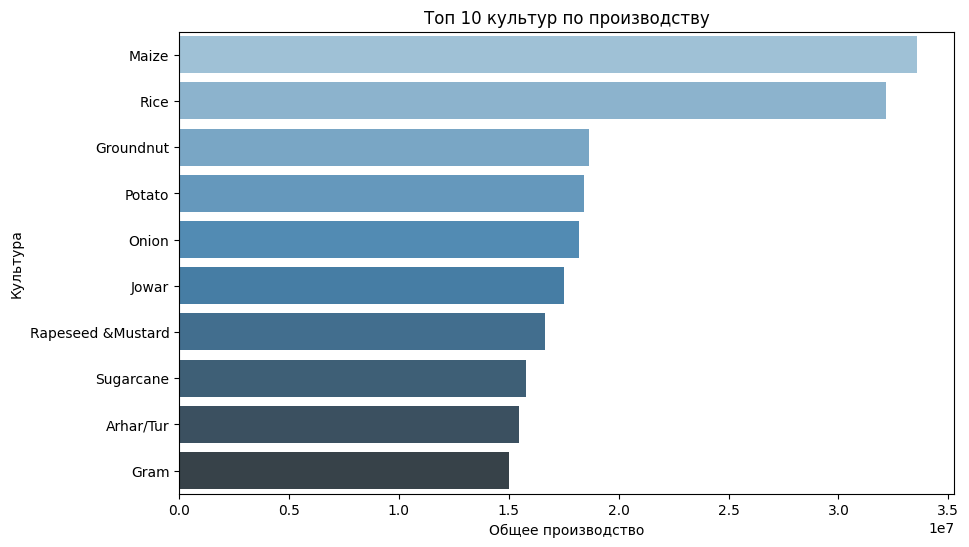

In [326]:
top_crops = aggregated_crops.sort_values(by='Total_Production', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Production', y='Crop', data=top_crops, palette='Blues_d')
plt.title('Топ 10 культур по производству')
plt.xlabel('Общее производство')
plt.ylabel('Культура')
plt.show()

2) Распределение среднего производства по сезонам

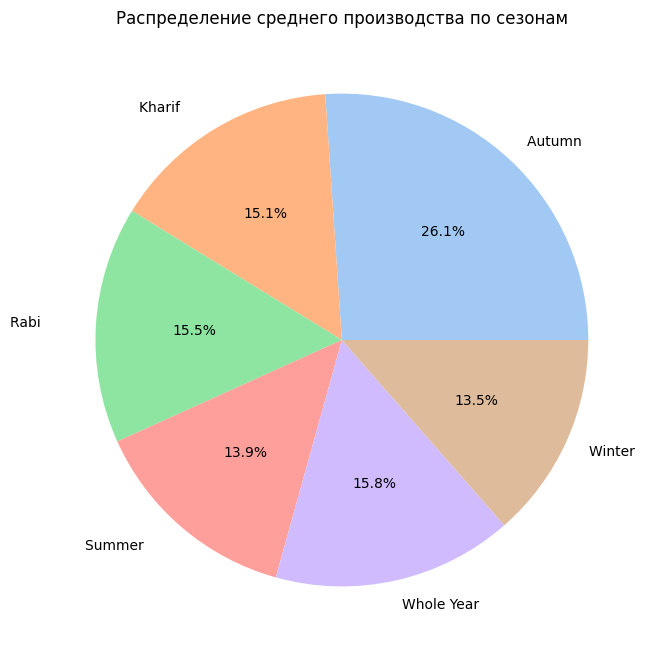

In [327]:
plt.figure(figsize=(8, 8))
plt.pie(
    aggregated_seasons['Avg_Production'],
    labels=aggregated_seasons['Season'],
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel')
)
plt.title('Распределение среднего производства по сезонам')
plt.show()

3) Топ 10 штатов по общему производству

C:\Users\haryuuno\AppData\Local\Temp\ipykernel_16648\1353020710.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='State_Name', y='Production', data=top_states, palette='Oranges_d')


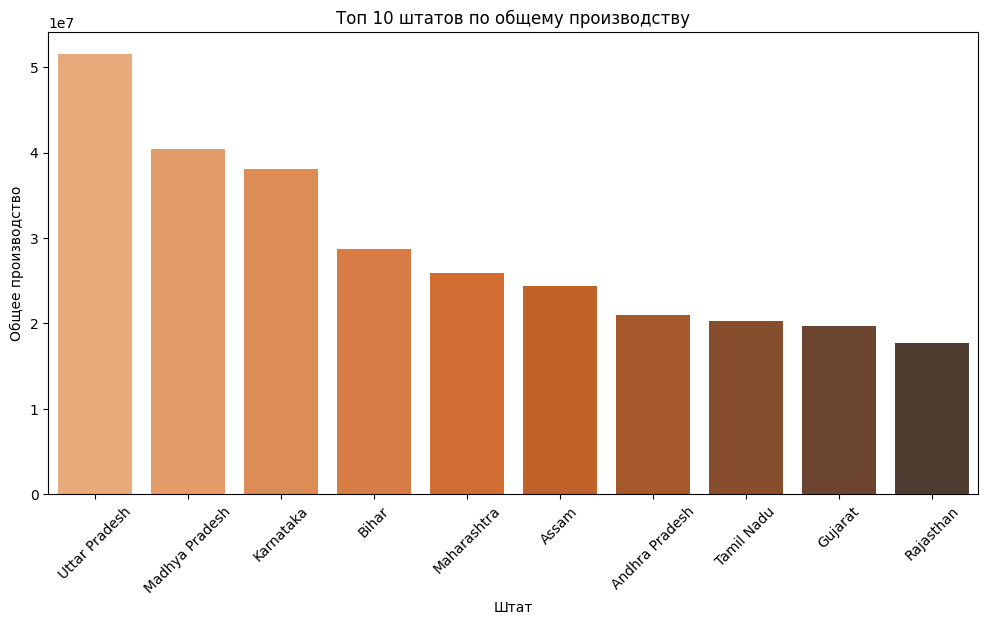

In [328]:
top_states = state_production.sort_values(by='Production', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='State_Name', y='Production', data=top_states, palette='Oranges_d')
plt.title('Топ 10 штатов по общему производству')
plt.xlabel('Штат')
plt.ylabel('Общее производство')
plt.xticks(rotation=45)
plt.show()

4) Производство по годам

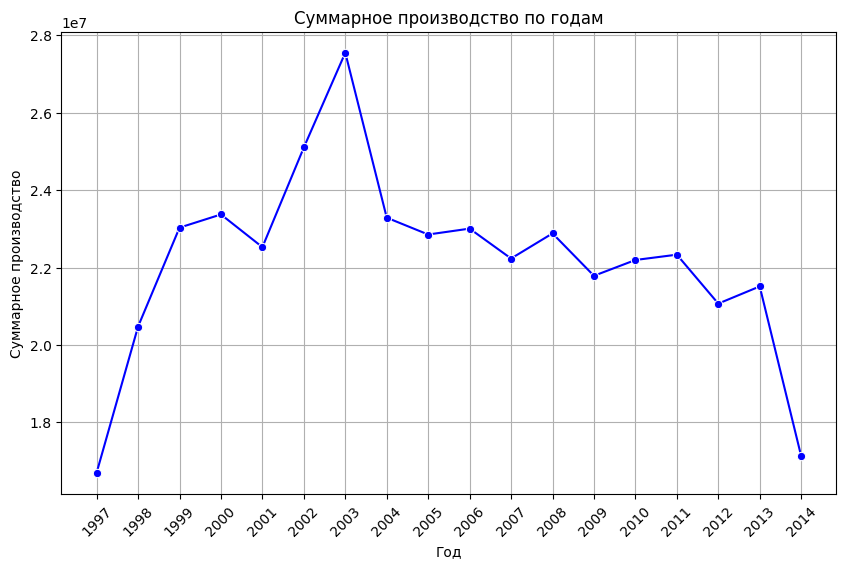

In [329]:
filtered_years = aggregated_years[aggregated_years['Crop_Year'] != 2015]

years = np.arange(filtered_years['Crop_Year'].min(), filtered_years['Crop_Year'].max() + 1, 1)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Crop_Year', y='Sum_Production', data=filtered_years, marker='o', color='b')
plt.title('Суммарное производство по годам')
plt.xlabel('Год')
plt.ylabel('Суммарное производство')

plt.xticks(years, rotation=45)  # Поворот подписей для удобства чтения

plt.grid()

plt.show()


5) Топ 10 культур по урожайности

C:\Users\haryuuno\AppData\Local\Temp\ipykernel_16648\2301494155.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_Yield', y='Crop', data=top_crops, palette='Blues_d')


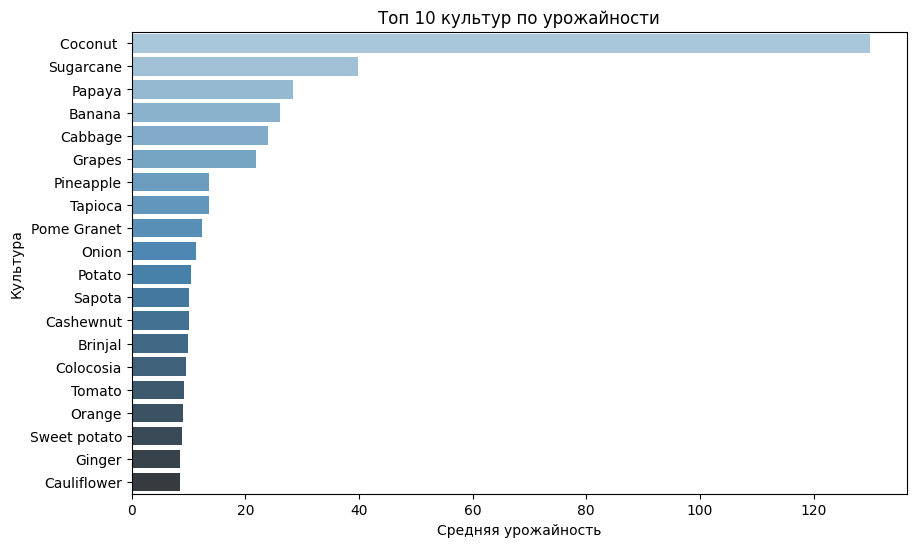

In [330]:
top_crops = avg_yield.sort_values(by='Avg_Yield', ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='Avg_Yield', y='Crop', data=top_crops, palette='Blues_d')
plt.title('Топ 10 культур по урожайности')
plt.xlabel('Средняя урожайность')
plt.ylabel('Культура')
plt.show()

<Figure size 1500x1000 with 0 Axes>

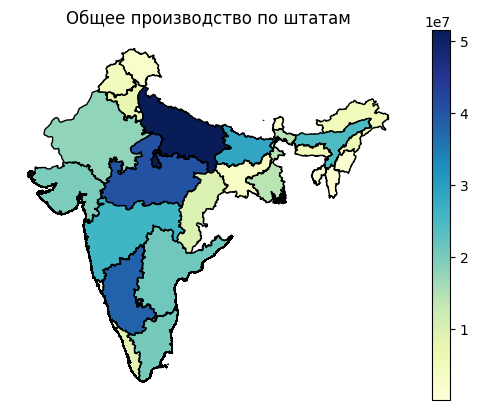

In [331]:
india_geo = gpd.read_file('india_state_geo.json')

india_geo = india_geo.merge(state_production, left_on='NAME_1', right_on='State_Name', how='left')

plt.figure(figsize=(15, 10))
india_geo.plot(column='Production', cmap='YlGnBu', legend=True, edgecolor='black')
plt.title('Общее производство по штатам')
plt.axis('off')
plt.show()

#### Проверка гипотез
1) Производство (Production) прямо пропорционально площади (Area).

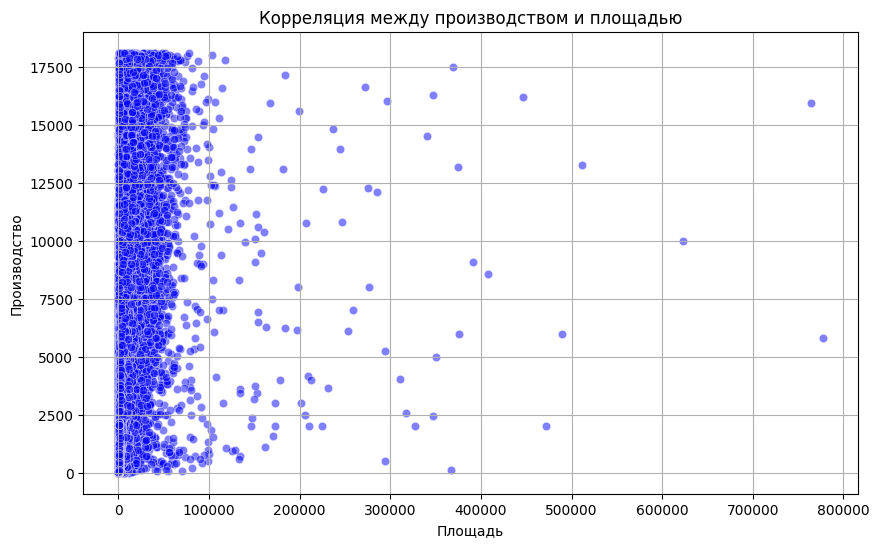

Коэффициент корреляции между площадью и производством: 0.43
P-value: 0.00e+00


In [332]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Area', y='Production', data=data, alpha=0.5, color='blue') # Диаграмма рассеяния
plt.title('Корреляция между производством и площадью')
plt.xlabel('Площадь')
plt.ylabel('Производство')
plt.grid()
plt.show()

correlation, p_value = pearsonr(data['Area'], data['Production'])
print(f"Коэффициент корреляции между площадью и производством: {correlation:.2f}")
print(f"P-value: {p_value:.2e}")

2) Общее производство культур в Индии уменьшается с годами

d:\Documents\my_nirs\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


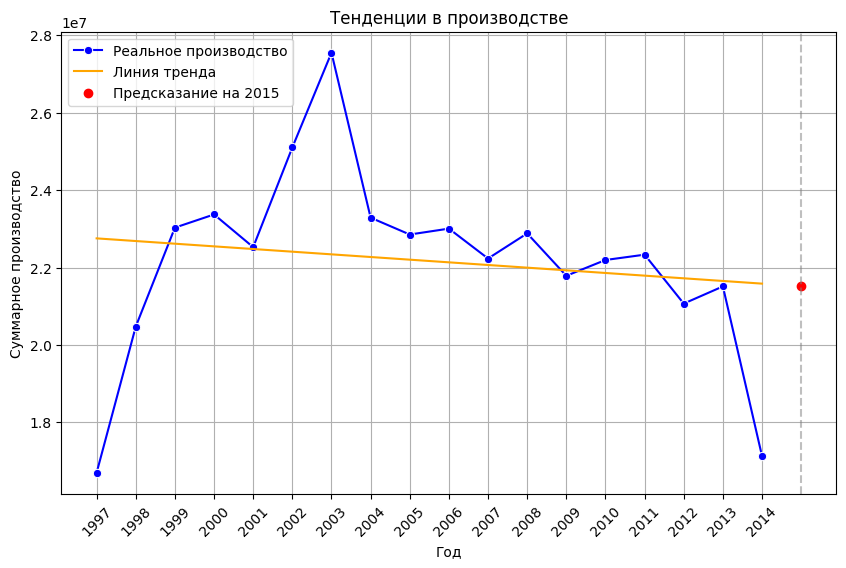

Предсказанное суммарное производство для 2015 года: 21,515,093.56


In [333]:
X = filtered_years[['Crop_Year']]  # Признак (год)
y = filtered_years['Sum_Production']  # Целевая переменная (производство)

model = LinearRegression()
model.fit(X, y)

# Предсказание для следующего года
next_year = np.array([[filtered_years['Crop_Year'].max() + 1]])
predicted_production = model.predict(next_year)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Crop_Year', y='Sum_Production', data=filtered_years, marker='o', color='blue', label='Реальное производство')

# Добавление линии тренда
sns.lineplot(x=filtered_years['Crop_Year'], y=model.predict(X), color='orange', label='Линия тренда')

plt.scatter(next_year, predicted_production, color='red', label=f'Предсказание на {next_year[0][0]}')
plt.axvline(x=next_year[0][0], linestyle='--', color='gray', alpha=0.5)

years = np.arange(filtered_years['Crop_Year'].min(), filtered_years['Crop_Year'].max() + 1, 1)

plt.title('Тенденции в производстве')
plt.xlabel('Год')
plt.ylabel('Суммарное производство')
plt.xticks(years, rotation=45)
plt.legend()
plt.grid()
plt.show()

print(f"Предсказанное суммарное производство для {next_year[0][0]} года: {predicted_production[0]:,.2f}")


3) Некоторые культуры выращиваются исключительно в определённые сезоны.

Культуры, выращиваемые только в одном сезоне: 29


C:\Users\haryuuno\AppData\Local\Temp\ipykernel_16648\1332213507.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Unique_Seasons', data=crop_seasons, palette='Set2')


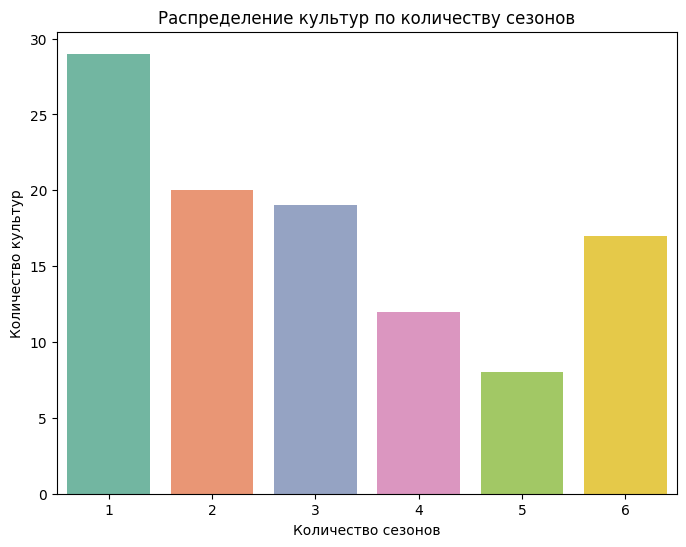

In [334]:
crop_seasons = data.groupby('Crop')['Season'].nunique().reset_index()
crop_seasons.columns = ['Crop', 'Unique_Seasons']

single_season_crops = crop_seasons[crop_seasons['Unique_Seasons'] == 1]

print(f"Культуры, выращиваемые только в одном сезоне: {len(single_season_crops)}")

plt.figure(figsize=(8, 6))
sns.countplot(x='Unique_Seasons', data=crop_seasons, palette='Set2')
plt.title('Распределение культур по количеству сезонов')
plt.xlabel('Количество сезонов')
plt.ylabel('Количество культур')
plt.show()

4) Производство одной и той же культуры значительно отличается в зависимости от штата

C:\Users\haryuuno\AppData\Local\Temp\ipykernel_16648\1712737716.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Production', y='State_Name', data=filtered_data, palette='Set3')


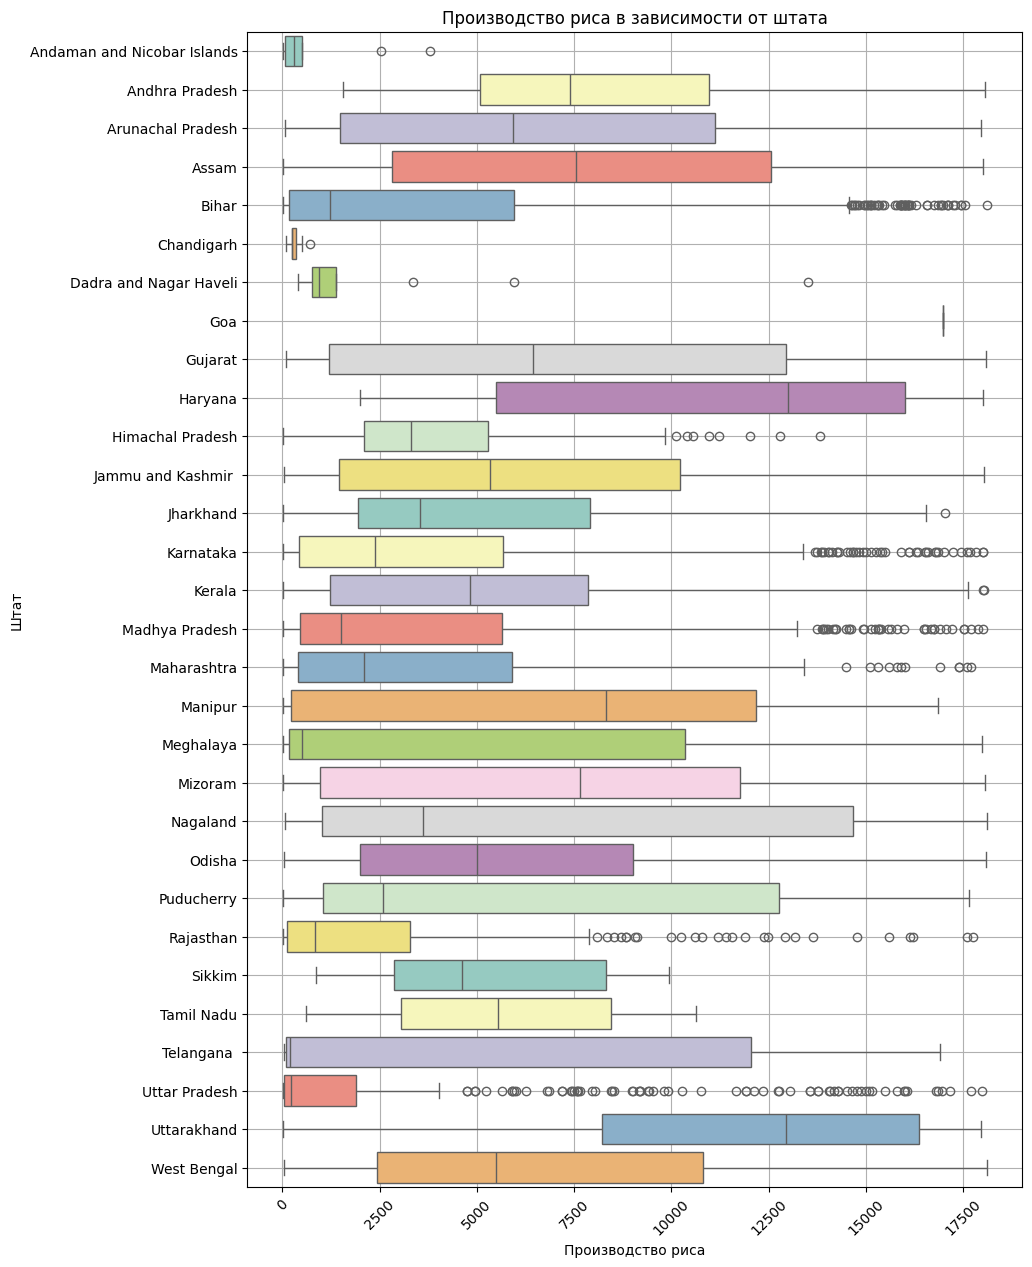

ANOVA Test Result for Rice: F-statistic = 34.86, p-value = 0.0000


In [335]:
filtered_data = data[data['Crop'] == 'Rice']

state_production = filtered_data.groupby('State_Name')['Production'].sum().reset_index()

plt.figure(figsize=(10, 15))
sns.boxplot(x='Production', y='State_Name', data=filtered_data, palette='Set3')
plt.title('Производство риса в зависимости от штата')
plt.xlabel('Производство риса')
plt.ylabel('Штат')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Статистический тест ANOVA (дисперсионный анализ)
states = [group['Production'].values for _, group in filtered_data.groupby('State_Name')]
anova_result = f_oneway(*states)
print(f"ANOVA Test Result for Rice: F-statistic = {anova_result.statistic:.2f}, p-value = {anova_result.pvalue:.4f}")


5) В каждом штате есть одна преобладающая культура, которая производится в значительно больших объемах по сравнению с другими

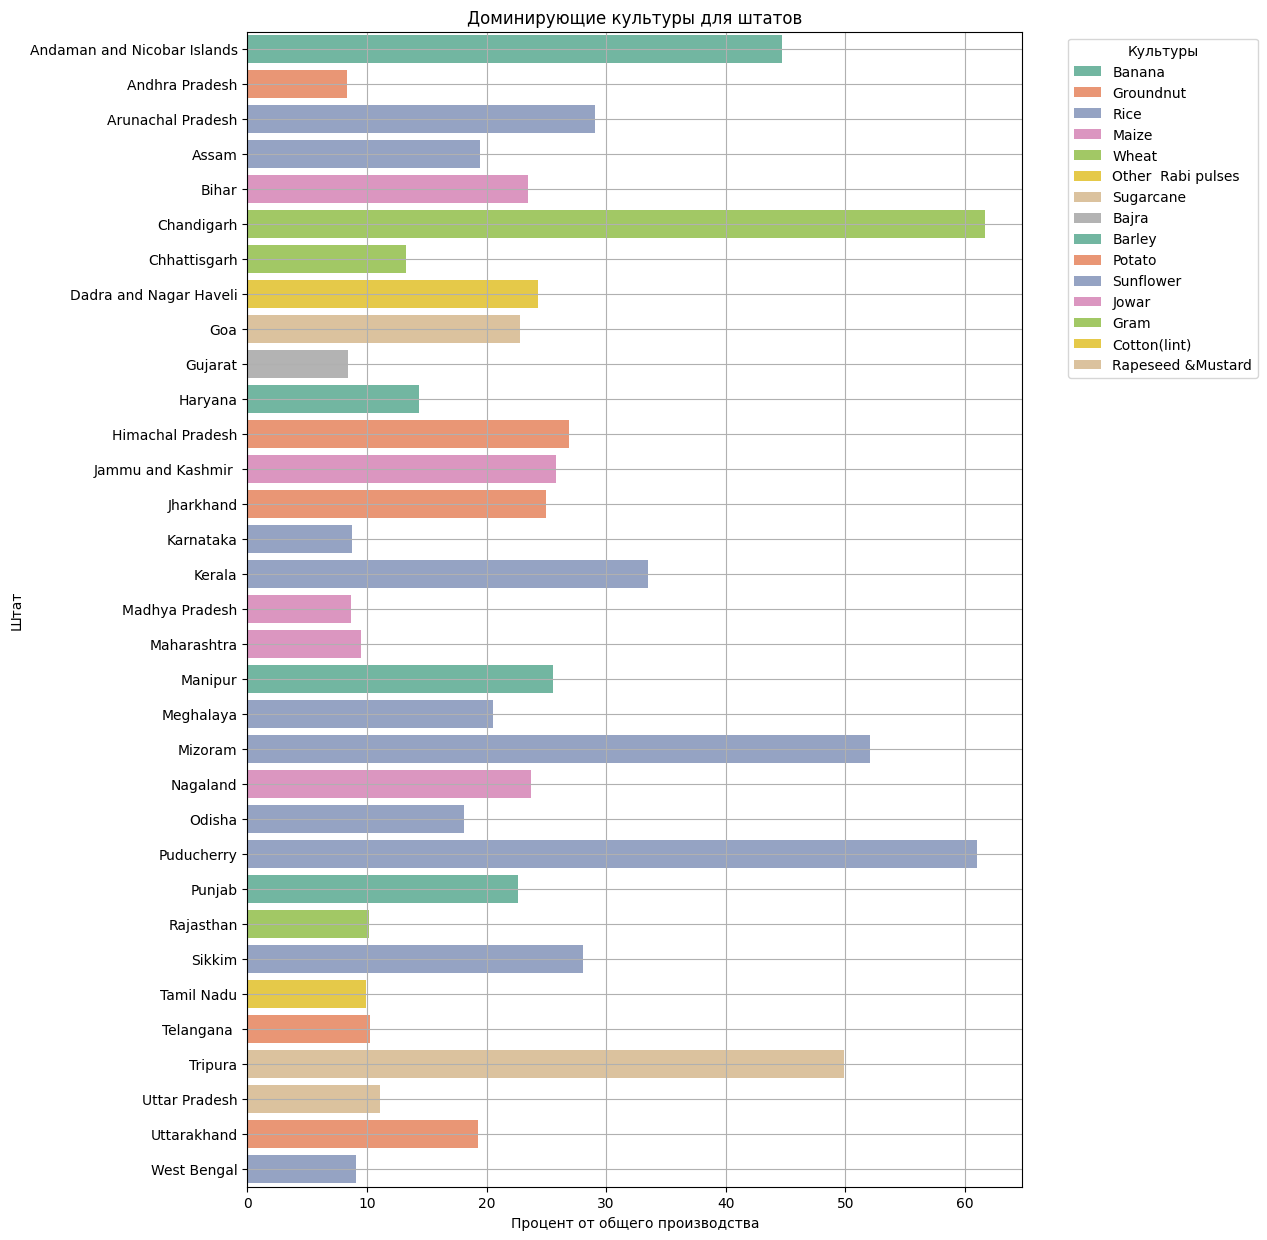

In [336]:
state_total_production = aggregated_states.groupby('State_Name')['Sum_Production'].sum().reset_index()
state_total_production.rename(columns={'Sum_Production': 'Total_Production'}, inplace=True)
aggregated_states = aggregated_states.merge(state_total_production, on='State_Name')
aggregated_states['Percentage'] = (aggregated_states['Sum_Production'] / aggregated_states['Total_Production']) * 100

dominant_crops = aggregated_states.loc[aggregated_states.groupby('State_Name')['Percentage'].idxmax()]

plt.figure(figsize=(10, 15))
sns.barplot(x='Percentage', y='State_Name', hue='Crop', data=dominant_crops, dodge=False, palette='Set2')
plt.title('Доминирующие культуры для штатов')
plt.xlabel('Процент от общего производства')
plt.ylabel('Штат')
plt.legend(title='Культуры', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

#### Корреляционная матрица
1) Корреляция Пирсона

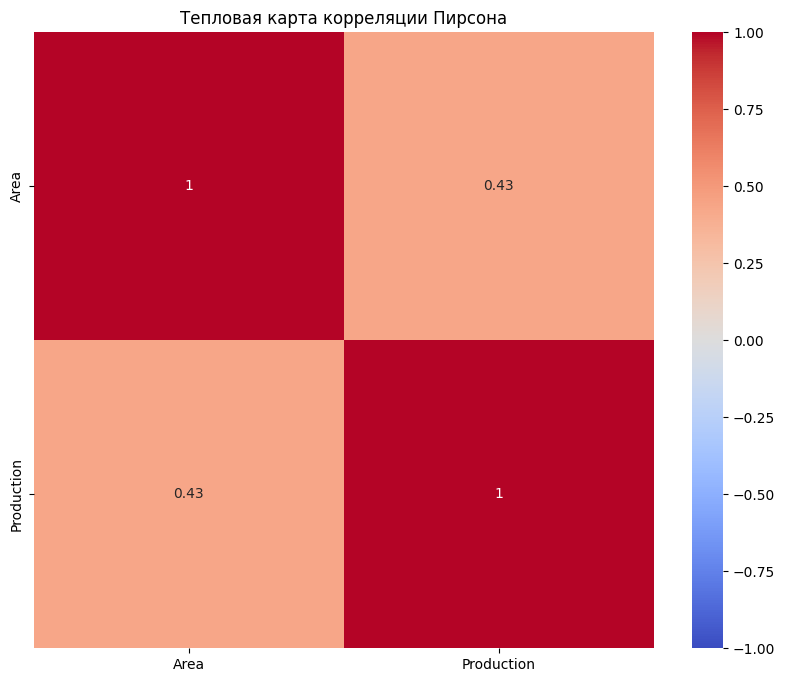

In [337]:
numeric_cols = ['Area','Production']
numeric_data = data[numeric_cols]

correlation_matrix = numeric_data.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Тепловая карта корреляции Пирсона")
plt.show()

2) Корреляция Спирмена

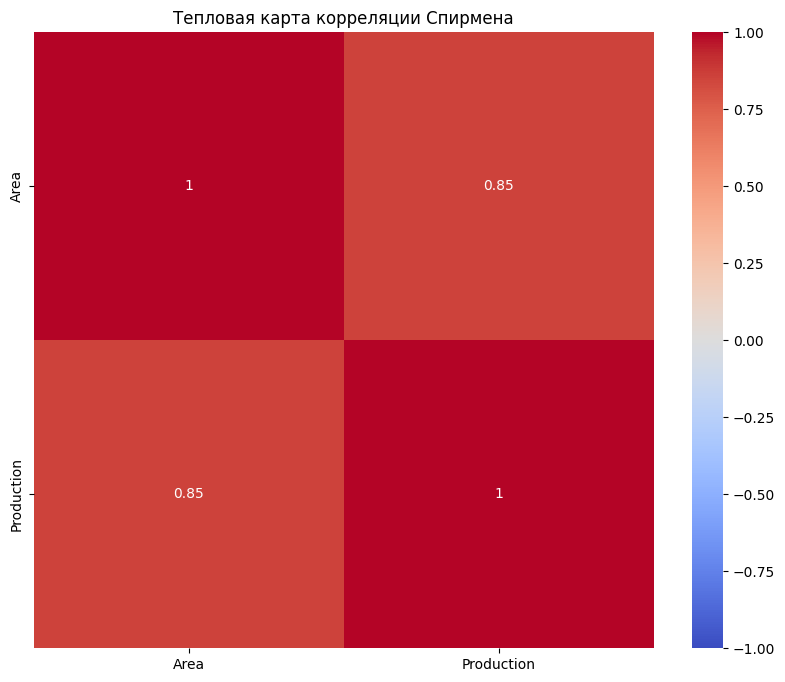

In [338]:
numeric_cols = ['Area','Production']
numeric_data = data[numeric_cols]

correlation_matrix = numeric_data.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Тепловая карта корреляции Спирмена")
plt.show()